In [228]:
import numpy as np
import polars as pl
from utils.prep import *
from skimage import measure
import matplotlib.pyplot as plt
from scipy.stats import mode

def init_hist(bin_img):
    life_dict = {
    }
    labeled_img = measure.label(bin_img)
    unique_labels = np.unique(labeled_img[labeled_img > 0])
    for label in unique_labels:
        life_dict[int(label)] = {
            "birth": 0,
            "death": None
        }
    if len(unique_labels) > 0:
        max_cur_label = np.max(unique_labels)
    else:
        max_cur_label = 0
    return life_dict, labeled_img, max_cur_label

def update_hist(prev_labeled_img, cur_bin, life_dict, max_cur_label, timestep):
    labeled_img = measure.label(cur_bin)
    ids = np.unique(labeled_img)[1:] # exclude blackground
    new_labeled_img = np.zeros(labeled_img.shape).astype(int)

    if np.sum(cur_bin) > 0:
        # find overlap objects
        overlap_hist = []
        new_non_overlap_ids = []
        for id in ids:
            overlap_ids = (labeled_img == id) * prev_labeled_img
            if np.max(overlap_ids) > 0:
                overlap_id = np.max(overlap_ids[overlap_ids > 0])
                overlap_hist.append(
                    [id, overlap_id] # new_id, old_id
                )
            else:
                new_non_overlap_ids.append(id)
        
        if len(overlap_hist) > 0:
            df = pl.DataFrame(np.array(overlap_hist), schema=["new_id", "old_id"]) \
                .with_columns(
                    pl.len().over("old_id").alias("intersect")
                ) \
                .with_columns(
                    pl.when(pl.col("intersect") > 1)
                    .then(0).otherwise(1)
                    .alias("alive")
                )

            death_df = df.filter(pl.col("alive") == 0)
            alive_df = df.filter(pl.col("alive") == 1)
            alive_prev_ids = alive_df.select("old_id").unique().to_series().to_list() # id of prev
            new_cur_ids = sorted(death_df.select("new_id").unique().to_series().to_list()) # id of cur
            #print(alive_prev_ids)

            for i, new_id in enumerate(new_cur_ids):
                new_labeled_img += (labeled_img == new_id) * (max_cur_label + i + 1)
            for alive_id in alive_prev_ids:
                new_labeled_img += ((prev_labeled_img == alive_id) & (labeled_img > 0)) * alive_id

            # update death -> life_dict
            for id in life_dict.keys():
                if (id not in new_labeled_img) and (life_dict[id]["death"] is None):
                    life_dict[id]["death"] = timestep

            # update birth -> life_dict
            for i in range(len(new_cur_ids)):
                new_label = int(max_cur_label + i + 1)
                life_dict[new_label] = {"birth": timestep, "death": None}
            max_cur_label += len(new_cur_ids)
        
        if len(new_non_overlap_ids) > 0:
            for i, new_id in enumerate(new_non_overlap_ids):
                new_labeled_img += (labeled_img == new_id) * (max_cur_label + i + 1)
            # update birth -> life_dict
            for i in range(len(new_non_overlap_ids)):
                new_label = int(max_cur_label + i + 1)
                life_dict[new_label] = {"birth": timestep, "death": None}
            max_cur_label += len(new_non_overlap_ids)
    else:
        # all dead
        for k in life_dict.keys():
            if life_dict[k]["death"] is None:
                life_dict[k]["death"] = timestep
        
    return life_dict, new_labeled_img, max_cur_label

In [229]:
# start func here
tmp_bin_img = np.array([
        [0,1,1,0],
        [0,1,1,0],
        [0,1,1,0],
        [0,0,0,0],
        [0,0,1,0],
        [0,0,0,0],
        [1,1,1,1],
    ])
life_dict, labeled_img, max_cur_label = init_hist(tmp_bin_img)
print(life_dict)
print(labeled_img)
#print(max_cur_label)
# ===========================================
cur_bin = np.array([
        [0,1,1,0],
        [0,0,0,0],
        [0,1,1,0],
        [0,0,0,0],
        [0,0,1,0],
        [0,0,0,0],
        [1,0,0,1],
    ])

timestep = 1
life_dict, new_labeled_img, max_cur_label = update_hist(labeled_img, cur_bin, life_dict, max_cur_label, timestep)
print(life_dict)
print(new_labeled_img)
#print(max_cur_label)
# ===========================================
new_bin = np.array([
    [0,1, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [1, 0, 0, 0],
])

timestep = 2
life_dict2, new_labeled_img2, max_cur_label2 = update_hist(new_labeled_img, new_bin, life_dict, max_cur_label, timestep)
print(life_dict2)
print(new_labeled_img2)
# #print(max_cur_label2)
# ===========================================
new_bin2 = np.array([
    [0,1, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
])

timestep = 3
life_dict3, new_labeled_img3, max_cur_label3 = update_hist(new_labeled_img2, new_bin2, life_dict2, max_cur_label, timestep)
print(life_dict3)
print(new_labeled_img3)
# #print(max_cur_label2)
# ===========================================
new_bin3 = np.array([
    [0,1, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 1],
])
timestep = 4
life_dict4, new_labeled_img4, max_cur_label4 = update_hist(new_labeled_img3, new_bin3, life_dict3, max_cur_label3, timestep)
print(life_dict4)
print(new_labeled_img4)
# ===========================================
new_bin4 = np.array([
    [0,0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 1],
])
timestep = 5
life_dict5, new_labeled_img5, max_cur_label5 = update_hist(new_labeled_img4, new_bin4, life_dict4, max_cur_label4, timestep)
print(life_dict5)
print(new_labeled_img5)
# ===========================================
new_bin5 = np.array([
    [0,0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
])
timestep = 6
life_dict6, new_labeled_img6, max_cur_label6 = update_hist(new_labeled_img5, new_bin5, life_dict5, max_cur_label5, timestep)
print(life_dict6)
print(new_labeled_img6)
# ===========================================
new_bin6 = np.array([
    [0,0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 1, 1, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
])
timestep = 7
life_dict7, new_labeled_img7, max_cur_label7 = update_hist(new_labeled_img6, new_bin6, life_dict6, max_cur_label6, timestep)
print(life_dict7)
print(new_labeled_img7)

{1: {'birth': 0, 'death': None}, 2: {'birth': 0, 'death': None}, 3: {'birth': 0, 'death': None}}
[[0 1 1 0]
 [0 1 1 0]
 [0 1 1 0]
 [0 0 0 0]
 [0 0 2 0]
 [0 0 0 0]
 [3 3 3 3]]
{1: {'birth': 0, 'death': 1}, 2: {'birth': 0, 'death': None}, 3: {'birth': 0, 'death': 1}, 4: {'birth': 1, 'death': None}, 5: {'birth': 1, 'death': None}, 6: {'birth': 1, 'death': None}, 7: {'birth': 1, 'death': None}}
[[0 4 4 0]
 [0 0 0 0]
 [0 5 5 0]
 [0 0 0 0]
 [0 0 2 0]
 [0 0 0 0]
 [6 0 0 7]]
{1: {'birth': 0, 'death': 1}, 2: {'birth': 0, 'death': 2}, 3: {'birth': 0, 'death': 1}, 4: {'birth': 1, 'death': None}, 5: {'birth': 1, 'death': None}, 6: {'birth': 1, 'death': None}, 7: {'birth': 1, 'death': 2}}
[[0 4 0 0]
 [0 0 0 0]
 [0 0 5 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [6 0 0 0]]
{1: {'birth': 0, 'death': 1}, 2: {'birth': 0, 'death': 2}, 3: {'birth': 0, 'death': 1}, 4: {'birth': 1, 'death': None}, 5: {'birth': 1, 'death': None}, 6: {'birth': 1, 'death': 3}, 7: {'birth': 1, 'death': 2}}
[[0 4 0 0]
 [0 0 0 0]
 [0 0

In [230]:
def get_dab(img):
    # gray macenko
    normalizer = NumpyMacenkoNormalizer()
    normalizer.fit(img)
    Inorm, H, DAB, C2 = normalizer.normalize(img)
    c = C2[1].reshape(img.shape[:-1])
    gray = np.round((c - c.min()) / (c.max() - c.min()) * 255).astype(np.uint8)
    return gray

def white_balance(img, q=99):
    norm_img = (img / np.percentile(img, axis=(0, 1), q=q)).clip(0, 1) * 255
    return np.round(norm_img).astype(np.uint8)

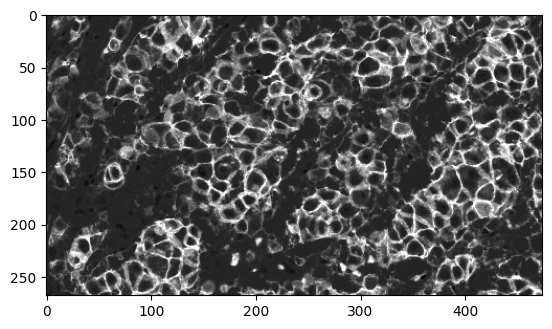

In [231]:
path = "/home/surayuth/her2/Data_Chula/09 Nov 22 3+ DISH+/HER2 3+ Dish+ (3).jpg"
img = read_image(path)
gray = white_balance(get_dab(img))
bg_mode = int(mode(gray.reshape(-1)).mode)
plt.imshow(gray, cmap="gray")

In [232]:
prep_gray = gray * (gray > int(bg_mode) * 1.)

In [233]:
def prep_mask(mask):
    labeled_image = measure.label(mask)
    regions = measure.regionprops(labeled_image)
    h, w = labeled_image.shape
    min_area = h * w * (0.01) ** 2
    max_area = h * w * (0.05) ** 2
    selected_labels = []
    for r in regions:
        area = r.area
        if (area > min_area) and (area < max_area):
            selected_labels.append(r.label)
    # Create a boolean mask where elements in arr are in values_to_select
    mask = np.isin(labeled_image, selected_labels)
    return mask

timestep = 0
max_th = 255
life_dict, labeled_img, max_cur_label = init_hist(prep_mask(prep_gray < max_th + 1))
for th in np.arange(1,max_th)[::-1]:
    timestep += 1
    print(timestep)
    life_dict, labeled_img, max_cur_label = update_hist(labeled_img, prep_mask(prep_gray < th), life_dict, max_cur_label, timestep)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254


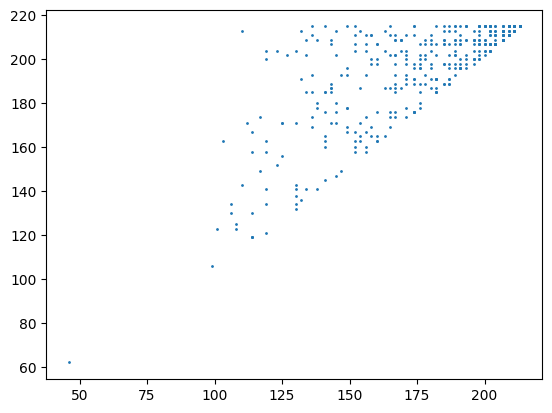

In [234]:
births = []
deaths = []
for k, v in life_dict.items():
    b = v["birth"]
    d = v["death"]
    if d is not None:
        births.append(b)
        deaths.append(d)

births = np.array(births)
deaths = np.array(deaths)
lifespan = deaths - births
plt.scatter(births, deaths, s=1)

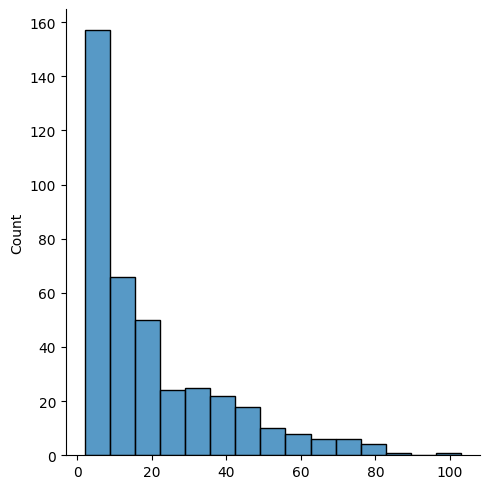

In [235]:
import seaborn as sns
sns.displot(data=lifespan)